# Spoken Digit Experiment for Progressive Learning

This experiment will use an audio dataset named spoken_digit (https://github.com/Jakobovski/free-spoken-digit-dataset) to test the performance of progressive-learning on audio classification tasks. The dataset consists of 3,000 recordings of digit (from 0 to 9) pronounced in English, by 6 speakers: 6 (speakers) x 10 (digits) x 50 (repetitions) = 3,000 (audio files). Think MNIST for audio.


### Import necessary packages and modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import librosa 
import librosa.display
import cv2
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

### Load spoken_digit data and extract features
To try on the up-to-date version of spoken_digit, we download the dataset from github repo (https://github.com/Jakobovski/free-spoken-digit-dataset) to our computer.

Then we use `librosa` to load audio file, and extract the **STFT** (Short-time Fourier transform) feature. Since each audio has different durations, the STFT spectrograms vary in width. For convenience, we regularize the STFT spectrograms all to 28 by 28 images, using .resize() function from `opencv`.


In [2]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')
AudioData=[]       # audio data
X_spec = []        # STFT spectrogram
X_spec_mini = []   # resized image, 28*28
Y_number = []      # label of number
Y_speaker = []     # label of speaker

Label_speaker = ['g', 'j', 'l', 'n', 't', 'y'] # first letter of speaker's name

for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i, sr = 8000) # path of the audio files
    X = librosa.stft(x,n_fft = 128) # STFT
    Xdb = librosa.amplitude_to_db(abs(X)) # Convert an amplitude spectrogram to dB-scaled spectrogram
    Xdb_28 = cv2.resize(Xdb, (28, 28)) # resize into 28 by 28
    y_n = i[0] # number
    y_s = i[2] # first letter of speaker's name
    
    AudioData.append(x)
    X_spec.append(Xdb)
    X_spec_mini.append(Xdb_28)
    Y_number.append(y_n)
    Y_speaker.append(y_s)

# Flattening
X_all = np.array(X_spec_mini).reshape(3000,-1) # (3000, 784)
Y_all = np.array(Y_number).astype(int) # (3000,)
Y_all_speaker = np.array(Y_speaker) # (3000,), type: string

***Before running progressive learning, let's take a look at what we have now!***

In [3]:
# Play the audio
import IPython.display as ipd

num = 2222 # choose an audio to play, 0-2999
print('This is a number',Y_number[num],'spoken by speaker',Y_speaker[num].upper(),'\nLength:',AudioData[num].shape[0],'points')
ipd.Audio(AudioData[num], rate=sr)

This is a number 7 spoken by speaker L 
Length: 10399 points


Text(0.5, 1.0, '28x28')

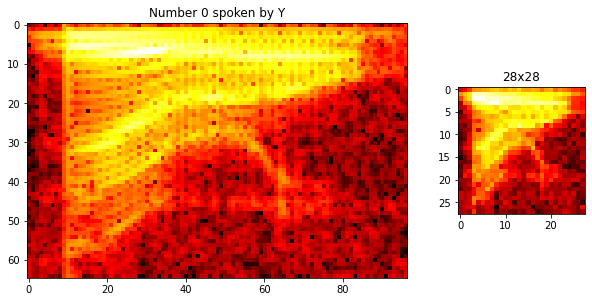

In [4]:
# Resized image
num = 250 # choose from 0 to 2999
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(10, 8),gridspec_kw={'width_ratios': [3, 1]})
axs[0].imshow(X_spec[num], cmap='hot', interpolation='nearest')
axs[0].set_title('Number '+Y_number[num]+' spoken by '+Y_speaker[num].upper())

axs[1].imshow(X_spec_mini[num], cmap='hot', interpolation= 'nearest')
axs[1].set_title('28x28')

Text(0.5, 0.98, 'Short-Time Fourier Transform Spectrograms of Number 5')

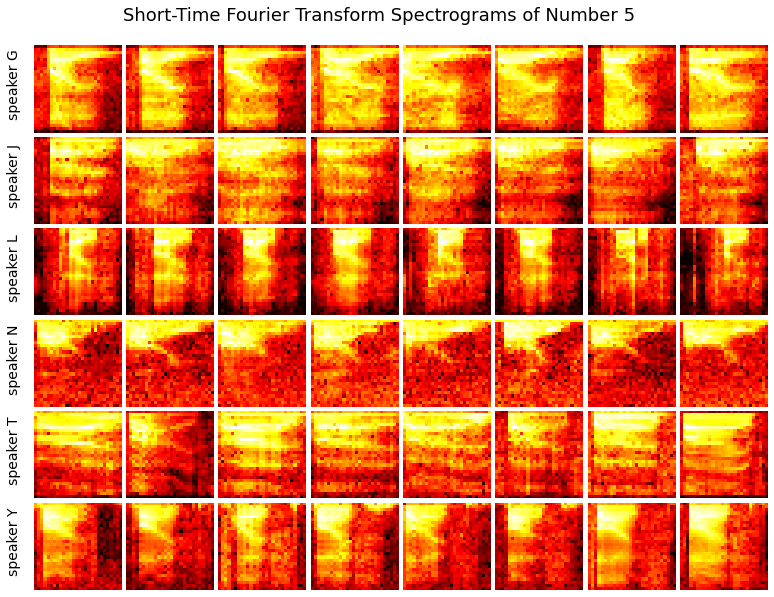

In [5]:
# Spectrograms of same number spoken by different speakers
number = 5 # choose number between 0 and 9
fig, axes = plt.subplots(nrows=6, ncols=8, sharex=True, sharey=True, figsize=(12, 9))

for j,speaker in enumerate(Label_speaker):
    opt = np.where((Y_all_speaker == speaker)&(Y_all == number))[0]
    ch = np.random.choice(opt,8,replace=False) #randomly choose 8 different samples for plotting
    #print(speaker)########these two lines were to check the index of chosen spectrograms
    #print(ch)#######remove in final version
    for i in range(8):
        axes[j,i].imshow(X_spec_mini[ch[i]], cmap='hot', interpolation='nearest')
        axes[j,i].axis('off')
        if i == 0: axes[j,i].text(-9, 12, 'speaker '+speaker.upper(), size=14, va='center', rotation='vertical')
        else: continue
                
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05,
                    wspace=0.05)
plt.suptitle("Short-Time Fourier Transform Spectrograms of Number "+str(number), fontsize=18)

### Run progressive learning
We divide the tasks by speaker, and check whether the later learned task will transfer knowledge to the former task.

Here are the major steps:
1. Shuffle the list of speakers.
2. Pick the first speaker. Split data into train set and test set. Add the first progressive learning task and learn on the train set. Make predictions on the test set. 
3. One by one, the rest of the speakers come as train data. We add transformers using these data, and backpropagate to the first task. Make predictions on the test set in step 2, using task 1.
4. Repeat hundreds of times and average the result.

In [6]:
############################
num_iteration = 100
ntrees = 19

model = 'uf' # uf or dnn, dnn is unuseable yet! And I don't know why.
speakers = Label_speaker.copy()
    
iteration = []
accuracies_across_tasks = []
############################

if model == "dnn":
    import keras
    from keras import layers
    default_transformer_class = NeuralClassificationTransformer

    network = keras.Sequential()
    network.add(
        layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=np.shape(train_x_task0)[1:],
        )
    )
    network.add(
        layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )
    network.add(
        layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )
    network.add(
        layers.Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )
    network.add(
        layers.Conv2D(
            filters=254,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )

    network.add(layers.Flatten())
    network.add(layers.Dense(2000, activation="relu"))
    network.add(layers.Dense(2000, activation="relu"))
    network.add(layers.Dense(units=10, activation="softmax"))

    default_transformer_kwargs = {
        "network": network,
        "euclidean_layer_idx": -2,
        "num_classes": 10,
        "optimizer": keras.optimizers.Adam(3e-4),
    }

    default_voter_class = KNNClassificationVoter
    default_voter_kwargs = {"k": int(np.log2(num_points_per_task * 0.33))}

    default_decider_class = SimpleArgmaxAverage
elif model == "uf":
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": 30}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    

for i in range(num_iteration):
    print('Iteration ',i)
    np.random.shuffle(speakers)
    for j , speaker in enumerate(speakers):
        index = np.where(Y_all_speaker==speaker)
        X = X_all[index]
        Y = Y_all[index]

        if j == 0:
            progressive_learner = ProgressiveLearner(
                default_transformer_class=default_transformer_class,
                default_transformer_kwargs=default_transformer_kwargs,
                default_voter_class=default_voter_class,
                default_voter_kwargs=default_voter_kwargs,
                default_decider_class=default_decider_class,
            )

            train_x_task0, test_x_task0, train_y_task0, test_y_task0 = train_test_split(X, Y, test_size=0.25)
            progressive_learner.add_task(
                X=train_x_task0,
                y=train_y_task0,
                task_id = 0,
                num_transformers= 1 if model == "dnn" else ntrees,
                transformer_voter_decider_split=[0.67, 0.33, 0],
                decider_kwargs={"classes": np.unique(train_y_task0)},
            )
            task_0_predictions = progressive_learner.predict(test_x_task0, task_id=0)
            iteration.append(i)
            accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))
            print('Task finished, current accuracy of task 1: ',accuracies_across_tasks[i*6:i*6+6])
        else:
            progressive_learner.add_transformer(
                X=X,
                y=Y,
                transformer_data_proportion=1,
                num_transformers=1 if model == "dnn" else ntrees,
                backward_task_ids=[0],
            )
            task_0_predictions = progressive_learner.predict(test_x_task0, task_id=0)
            iteration.append(i)
            accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))
            print('Task finished, current accuracy of task 1: ',accuracies_across_tasks[i*6:i*6+6])

print('All done!')

aver_accuracy = np.array(accuracies_across_tasks).reshape((num_iteration,6))
aver_accuracy = np.average(aver_accuracy,axis =0)

Iteration  0
Task finished, current accuracy of task 1:  [0.92]
Task finished, current accuracy of task 1:  [0.92, 0.92]
Task finished, current accuracy of task 1:  [0.92, 0.92, 0.928]
Task finished, current accuracy of task 1:  [0.92, 0.92, 0.928, 0.912]
Task finished, current accuracy of task 1:  [0.92, 0.92, 0.928, 0.912, 0.92]
Task finished, current accuracy of task 1:  [0.92, 0.92, 0.928, 0.912, 0.92, 0.912]
Iteration  1
Task finished, current accuracy of task 1:  [0.824]
Task finished, current accuracy of task 1:  [0.824, 0.824]
Task finished, current accuracy of task 1:  [0.824, 0.824, 0.848]
Task finished, current accuracy of task 1:  [0.824, 0.824, 0.848, 0.856]
Task finished, current accuracy of task 1:  [0.824, 0.824, 0.848, 0.856, 0.848]
Task finished, current accuracy of task 1:  [0.824, 0.824, 0.848, 0.856, 0.848, 0.848]
Iteration  2
Task finished, current accuracy of task 1:  [0.784]
Task finished, current accuracy of task 1:  [0.784, 0.792]
Task finished, current accura

Task finished, current accuracy of task 1:  [0.84, 0.896, 0.912]
Task finished, current accuracy of task 1:  [0.84, 0.896, 0.912, 0.92]
Task finished, current accuracy of task 1:  [0.84, 0.896, 0.912, 0.92, 0.928]
Task finished, current accuracy of task 1:  [0.84, 0.896, 0.912, 0.92, 0.928, 0.928]
Iteration  20
Task finished, current accuracy of task 1:  [0.952]
Task finished, current accuracy of task 1:  [0.952, 0.976]
Task finished, current accuracy of task 1:  [0.952, 0.976, 0.968]
Task finished, current accuracy of task 1:  [0.952, 0.976, 0.968, 0.976]
Task finished, current accuracy of task 1:  [0.952, 0.976, 0.968, 0.976, 0.968]
Task finished, current accuracy of task 1:  [0.952, 0.976, 0.968, 0.976, 0.968, 0.976]
Iteration  21
Task finished, current accuracy of task 1:  [0.816]
Task finished, current accuracy of task 1:  [0.816, 0.808]
Task finished, current accuracy of task 1:  [0.816, 0.808, 0.808]
Task finished, current accuracy of task 1:  [0.816, 0.808, 0.808, 0.8]
Task fin

Task finished, current accuracy of task 1:  [0.84, 0.832, 0.856, 0.864, 0.896]
Task finished, current accuracy of task 1:  [0.84, 0.832, 0.856, 0.864, 0.896, 0.864]
Iteration  39
Task finished, current accuracy of task 1:  [0.976]
Task finished, current accuracy of task 1:  [0.976, 0.984]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984, 0.992]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984, 0.992, 0.992]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984, 0.992, 0.992, 0.992]
Iteration  40
Task finished, current accuracy of task 1:  [0.976]
Task finished, current accuracy of task 1:  [0.976, 0.984]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984, 0.984]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0.984, 0.984, 0.992]
Task finished, current accuracy of task 1:  [0.976, 0.984, 0

Task finished, current accuracy of task 1:  [0.912]
Task finished, current accuracy of task 1:  [0.912, 0.968]
Task finished, current accuracy of task 1:  [0.912, 0.968, 0.96]
Task finished, current accuracy of task 1:  [0.912, 0.968, 0.96, 0.96]
Task finished, current accuracy of task 1:  [0.912, 0.968, 0.96, 0.96, 0.96]
Task finished, current accuracy of task 1:  [0.912, 0.968, 0.96, 0.96, 0.96, 0.96]
Iteration  59
Task finished, current accuracy of task 1:  [0.968]
Task finished, current accuracy of task 1:  [0.968, 0.968]
Task finished, current accuracy of task 1:  [0.968, 0.968, 0.984]
Task finished, current accuracy of task 1:  [0.968, 0.968, 0.984, 0.984]
Task finished, current accuracy of task 1:  [0.968, 0.968, 0.984, 0.984, 0.984]
Task finished, current accuracy of task 1:  [0.968, 0.968, 0.984, 0.984, 0.984, 0.984]
Iteration  60
Task finished, current accuracy of task 1:  [0.912]
Task finished, current accuracy of task 1:  [0.912, 0.912]
Task finished, current accuracy of ta

Task finished, current accuracy of task 1:  [0.752, 0.744, 0.736, 0.744]
Task finished, current accuracy of task 1:  [0.752, 0.744, 0.736, 0.744, 0.752]
Task finished, current accuracy of task 1:  [0.752, 0.744, 0.736, 0.744, 0.752, 0.768]
Iteration  78
Task finished, current accuracy of task 1:  [0.912]
Task finished, current accuracy of task 1:  [0.912, 0.912]
Task finished, current accuracy of task 1:  [0.912, 0.912, 0.952]
Task finished, current accuracy of task 1:  [0.912, 0.912, 0.952, 0.968]
Task finished, current accuracy of task 1:  [0.912, 0.912, 0.952, 0.968, 0.96]
Task finished, current accuracy of task 1:  [0.912, 0.912, 0.952, 0.968, 0.96, 0.968]
Iteration  79
Task finished, current accuracy of task 1:  [0.832]
Task finished, current accuracy of task 1:  [0.832, 0.872]
Task finished, current accuracy of task 1:  [0.832, 0.872, 0.88]
Task finished, current accuracy of task 1:  [0.832, 0.872, 0.88, 0.88]
Task finished, current accuracy of task 1:  [0.832, 0.872, 0.88, 0.88,

Task finished, current accuracy of task 1:  [0.904, 0.888, 0.904, 0.912, 0.912, 0.936]
Iteration  97
Task finished, current accuracy of task 1:  [0.952]
Task finished, current accuracy of task 1:  [0.952, 0.96]
Task finished, current accuracy of task 1:  [0.952, 0.96, 0.968]
Task finished, current accuracy of task 1:  [0.952, 0.96, 0.968, 0.976]
Task finished, current accuracy of task 1:  [0.952, 0.96, 0.968, 0.976, 0.976]
Task finished, current accuracy of task 1:  [0.952, 0.96, 0.968, 0.976, 0.976, 0.976]
Iteration  98
Task finished, current accuracy of task 1:  [0.976]
Task finished, current accuracy of task 1:  [0.976, 0.968]
Task finished, current accuracy of task 1:  [0.976, 0.968, 0.968]
Task finished, current accuracy of task 1:  [0.976, 0.968, 0.968, 0.976]
Task finished, current accuracy of task 1:  [0.976, 0.968, 0.968, 0.976, 0.976]
Task finished, current accuracy of task 1:  [0.976, 0.968, 0.968, 0.976, 0.976, 0.976]
Iteration  99
Task finished, current accuracy of task 1:

### Plot accuracy and backward transfer efficiency (task 1)

The backward transfer efficiency of $f_n$ for task $t$ given $n$ samples is 

$$BTE^t (f_n) := \mathbb{E} [R^t (f_n^{<t} )/R^t (f_n)]$$

We say an algorithm achieves backward transfer for task $t$ if and only if $BTE^t(f_n) > 1$. Intuitively, this means that the progressive learner has used data associated with new tasks to improve performance on previous tasks. 

Text(0.5, 1.0, 'L2F')

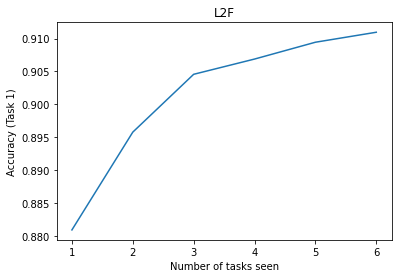

In [7]:
plt.figure()
plt.subplot()
plt.plot(range(1,7),aver_accuracy)
plt.xlabel('Number of tasks seen')
plt.ylabel('Accuracy (Task 1)')
plt.title('L2F')

Text(0.5, 1.0, 'L2F')

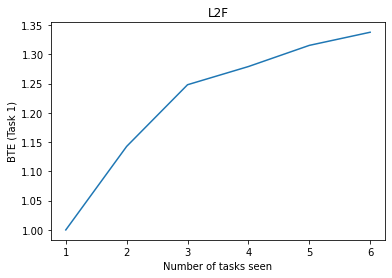

In [8]:
err = 1- aver_accuracy
bte = err[0]/err

plt.figure()
plt.subplot()
plt.plot(range(1,7),bte)
plt.xlabel('Number of tasks seen')
plt.ylabel('BTE (Task 1)')
plt.title('L2F')
